## Setup

In [0]:
# The code in this cell is only necessary when using Google Colab and storing 
# the data on Google Drive. If you don't use that combination, ignore it.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, fmin, rand, tpe, space_eval, tpe, Trials
from os import listdir
import pickle
from tensorflow.keras.utils import to_categorical

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

import skimage
from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc

print(tf.__version__)
print(np.__version__)

1.14.0
1.16.5


In [0]:
# Replace this path with the path to the directory you want to save the files 
# produced by this notebook in.
notebook_dir = '/content/drive/My Drive/Colab Notebooks/SVM/BA_SVM_Crossvalidation_Testset_Evaluation/'

# Replace these paths with the paths to the directories with your training 
# and testing data respectively.
# Each of the two directories should have three subdirectories named 'matrix',
# 'notype' and 'unpacking' with each subdirectory containing the images of the
# respective class.
train_data_dir = '/content/drive/My Drive/data3/train/'
test_data_dir = '/content/drive/My Drive/data3/validation/'

k_folds = 10
trial_id = 'first_trial'
nb_train_samples = 300
nb_test_samples = 30

## Load images

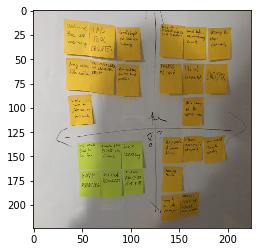

(224, 224, 3)
[1 0 0]
ndarray
ndarray


In [0]:
img_width, img_height = 224, 224

# loading datasets directly into memory beforehand - about 20 times faster when training
samples_x = []
samples_y = []
test_x = []
test_y = []

def add_class_from_dir(class_dir, label, data_x, data_y):
  class_samples = listdir(class_dir)
  for image in class_samples:
    img = load_img(path=class_dir + image, target_size=(img_height, img_width))
    data_x.append(img_to_array(img))
    data_y.append(label)

add_class_from_dir(class_dir=train_data_dir + 'matrix/', label=[1,0,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'notype/', label=[0,1,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'unpacking/', label=[0,0,1], data_x=samples_x, data_y=samples_y)

add_class_from_dir(class_dir=test_data_dir + 'matrix/', label=[1,0,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'notype/', label=[0,1,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'unpacking/', label=[0,0,1], data_x=test_x, data_y=test_y)

samples_x = np.array(samples_x)
test_x = np.array(test_x)
samples_y = np.array(samples_y)
test_y = np.array(test_y)

plt.figure()
plt.imshow(samples_x[0]/(255))
plt.show()
print(samples_x[0].shape)
print(samples_y[0])
print(type(samples_x).__name__)
print(type(test_x).__name__)

assert nb_train_samples == len(samples_x)
assert nb_test_samples == len(test_x)

## Feature extraction

grey x
[[205.84619  207.8462   205.84619  ... 146.27701  143.27701  144.277   ]
 [207.8462   205.84619  207.8462   ... 147.277    145.277    144.277   ]
 [207.8462   206.8462   206.8462   ... 144.277    147.277    143.27701 ]
 ...
 [201.27701  201.27701  199.277    ...  85.0549    84.05489   85.0549  ]
 [201.27701  200.277    198.277    ...  83.551994  83.551994  82.552   ]
 [200.277    198.277    200.277    ...  86.049095  85.049095  83.049095]]
hog
11664
[210. 205. 202. ...  92.  81.  77.]


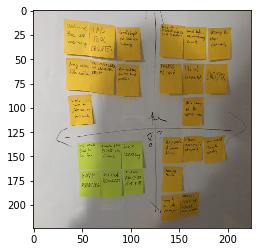

In [0]:
x = samples_x[0]
#print(x)
grey_image = rgb2grey(x)
print('grey x')
print(grey_image)
hog_features = hog(image=grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
print('hog')
print(len(hog_features))
y = x.flatten()
print(y)

plt.figure()
plt.imshow(x/(255))
plt.show()

In [0]:
hog_samples_x = []
for x in samples_x:
  grey_image = rgb2grey(x)
  hog_features = hog(image=grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
  hog_samples_x.append(hog_features)
hog_samples_x = np.array(hog_samples_x)
hog_samples_y = list(map(lambda x: np.argmax(x), samples_y))

## Train and cross-validate models

In [0]:
hyperparameter_space = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(estimator=svc, param_grid=hyperparameter_space, cv=k_folds)
clf.fit(hog_samples_x, hog_samples_y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print(clf.cv_results_)
print(clf.best_score_)
print(clf.best_params_)

{'mean_fit_time': array([1.78914962, 1.80590696, 1.80480027, 1.81067324, 1.89419003,
       1.89079542, 1.67684562, 1.82938173]), 'std_fit_time': array([0.01480661, 0.01109722, 0.01566359, 0.0147558 , 0.0203667 ,
       0.01105861, 0.02772963, 0.0255059 ]), 'mean_score_time': array([0.14564257, 0.14747641, 0.1474313 , 0.14870617, 0.16411066,
       0.16441808, 0.15439138, 0.15063748]), 'std_score_time': array([0.00187287, 0.00204259, 0.00222301, 0.00303755, 0.00163324,
       0.00277391, 0.00351006, 0.00308227]), 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'rbf', 'rbf',
                   'rbf', 'rbf'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}

## Evaluate model on test set and print confusion matrix

In [0]:
hog_test_x = []
for x in test_x:
  grey_image = rgb2grey(x)
  hog_features = hog(image=grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
  hog_test_x.append(hog_features)
hog_test_x = np.array(hog_test_x)
hog_test_y = list(map(lambda x: np.argmax(x), test_y))

y_pred = clf.predict(hog_test_x)

In [0]:
y_pred

array([0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 0, 2])

In [0]:
print("Classification report for - \n{}:\n{}\n".format(
    clf, classification_report(hog_test_y, y_pred)))

test_labels = list(map(lambda x: np.argmax(x), test_y))
sess = tf.Session()
with sess.as_default():
  print(tf.math.confusion_matrix(test_labels, y_pred).eval())
print(test_labels)
print(y_pred)

Classification report for - 
GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       1.00      0.40      0.57        10
           2       0.62      0.80      0.70        10

    accuracy                           

## Save model

In [0]:
import pickle
pickle.dump(clf, open(notebook_dir + 'svm.p', 'wb'))